In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Carga del dataset

Utilizando spark se realizo una partición del 2.5% de los datos del dataset original.

In [155]:
with open("header.txt", "r") as f:
    line = f.readline()
    cols = line.split(",")
    
df = pd.read_csv("data_sample.csv", header = None, sep = ",", names = cols)
df.head()

,periodo,id_cli,fecha_nacimiento,edad,genero,estado_civil,nivel_academico,profesion,ocupacion,tipo_vivienda,...,cuota_libranza_sf,cant_oblig_tot_sf,cant_cast_ult_12m_sr,ind,rep_calif_cred,pol_centr_ext,convenio_lib,ingreso_nomina,ingreso_segurida_social,gasto_familiar
0,202003,2089776,19840630,35.638604,M,DIVORCIADO,TECNOLOGO,TECNOLOGIA SISTEMAS,Empleado,ALQUILADA,...,0.0,0.0,0.0,695516.000,C,0.0,\N,1255032.0,NaN,304687.00
1,201902,2088089,19860727,32.476386,M,UNION LIBRE,NO INFORMA,\N,Independiente,FAMILIAR,...,0.0,NaN,NaN,1187025.000,SIN INFO,NaN,\N,NaN,NaN,187990.00
2,202001,3892351,19910108,28.936345,M,SOLTERO,TECNOLOGO,OTROS,Independiente,\N,...,0.0,NaN,NaN,3879251.250,SIN INFO,NaN,\N,NaN,NaN,862348.92
3,202008,2897552,19900903,29.883641,M,SOLTERO,BACHILLER,\N,Empleado,\N,...,0.0,0.0,1.0,210681.475,F,7.0,\N,NaN,1484205.0,1056864.00
4,202001,4782141,19790623,40.481862,F,NO INFORMA,SIN INFORMACION,\N,Empleado,\N,...,0.0,4.0,0.0,1615755.800,C,0.0,70831,4353538.0,3500000.0,248386.00


### Las siguientes variables no serán utilizadas dado que no aportan información relevante para el problema



In [156]:
df = df.drop(["periodo","id_cli","fecha_nacimiento","ult_actual","codigo_ciiu", "profesion",
              "departamento_residencia", "departamento_laboral", "convenio_lib","nro_tot_cuentas", 
              "ctas_embargadas", "ctas_activas", "cupo_tc_mdo", "cant_cast_ult_12m_sr", "pol_centr_ext",
              "cat_ingreso", "tiene_cred_hipo_1", "tiene_cred_hipo_2", "pension_fopep", "ciudad_residencia",
              "ciudad_laboral", "cuota_tc_bancolombia", "mora_max"], 
             axis = 1)

In [157]:
df.shape

(524623, 42)

## Tratamiento de variables categoricas

Primero se hace una eliminaciòn de valores nulos que no pueden ser imputados dada la naturaleza de la variable

In [158]:
df = df[df["rep_calif_cred"] != "SIN INFO"]
df = df[df["genero"] != " "]
df = df.dropna(subset = ["categoria", "edad"])

Luego hacemos una limpieza sobre los datos

In [159]:
def clean_civil_status(x: str) -> str:
    if x == "NO INFORMA" or x == "\\N": return "otro"
    return x.lower()

def clean_academic_level(x: str) -> str:
    if x == "NO INFORMA": return "sin informacion"
    return x.lower()

def clean_house_kind(x: str) -> str:
    if x == "\\N": return "no informa"
    return x.lower()

def clean_occupation(x: str) -> str:
    if x == "\\N" or x == "Sin Ocupacion Asignada" or x == "Vacío":
        return "otro"
    return x.lower()

In [160]:
df["estado_civil"] = df["estado_civil"].apply(clean_civil_status)
df["nivel_academico"] = df["nivel_academico"].apply(clean_academic_level)
df["tipo_vivienda"] = df["tipo_vivienda"].apply(clean_house_kind)
df["ocupacion"] = df["ocupacion"].apply(clean_occupation)

### Binarización de variables

En esta etapa además de limpiar las variables categoricas, se van a binarizar las que se utilizaran para el modelo

In [161]:
def binarize_yes_no(x: str) -> int:
    if x == "S" or x == "SI" or x == "X": return 1
    return 0

def binarize_genre(x: str) -> int:
    if x == "M": return 1
    return 0

def binarize_credit_refused(x: str) -> int:
    if x == "\\N": return 0
    return 1

def binarize_mora(x: float) -> int:
    if x > 0: return 1
    return 0
    

In [162]:
df["ind_mora_vigente"] = df["ind_mora_vigente"].apply(binarize_yes_no)
df["cartera_castigada"] = df["cartera_castigada"].apply(binarize_yes_no)
df["tenencia_tc"] = df["tenencia_tc"].apply(binarize_yes_no)
df["tiene_consumo"] = df["tiene_consumo"].apply(binarize_yes_no)
df["tiene_crediagil"] = df["tiene_crediagil"].apply(binarize_yes_no)
df["tiene_ctas_activas"] = df["tiene_ctas_activas"].apply(binarize_yes_no)
df["tiene_ctas_embargadas"] = df["tiene_ctas_embargadas"].apply(binarize_yes_no)
df["genero"] = df["genero"].apply(binarize_genre)
df["rechazo_credito"] = df["rechazo_credito"].apply(binarize_credit_refused)
df["cant_moras_30_ult_12_meses"] = df["cant_moras_30_ult_12_meses"].apply(binarize_mora)
df["cant_moras_60_ult_12_meses"] = df["cant_moras_60_ult_12_meses"].apply(binarize_mora)
df["cant_moras_90_ult_12_meses"] = df["cant_moras_90_ult_12_meses"].apply(binarize_mora)
df["cant_mora_30_tdc_ult_3m_sf"] = df["cant_mora_30_tdc_ult_3m_sf"].apply(binarize_mora)
df["cant_mora_30_consum_ult_3m_sf"] = df["cant_mora_30_consum_ult_3m_sf"].apply(binarize_mora)

### Categorización de la edad

In [163]:
def age_categorization(x: float) -> str:
    if x <= 27: return "Z"
    elif 27 < x <= 40: return "Y"
    elif 40 < x <= 52: return "X"
    else: return "BB"

In [164]:
df["edad"] = df["edad"].apply(age_categorization)

### One Hot Encoding

In [165]:
df["categoria"] = df["categoria"].astype(np.int64).astype(object)

In [166]:
categorical = df.select_dtypes(include=['object'])
names = categorical.columns

In [167]:
df = pd.get_dummies(df, prefix=names)

En el OHE, cuando se tratan las categorias, se puede eliminar una, ya que si no esta esa columna corresponderia con el caso nulo.

In [169]:
df = df.drop(["edad_BB", "estado_civil_casado", "nivel_academico_bachiller", 
              "ocupacion_agricultor", "tipo_vivienda_alquilada", "categoria_1",
              "rep_calif_cred_A"], axis = 1)

## Tratamiento de varibales numericas

Tratamiento de nulos

In [170]:
df = df.fillna(0)

Validación de valores negativos

In [171]:
numerical = df.select_dtypes(exclude=['object','int64'])

In [172]:
for col in numerical.columns:
    print(
        f"En la columna {col} hay valores negativos? {any(numerical[col] < 0)}"
    )

En la columna cupo_total_tc hay valores negativos? False
En la columna cuota_cred_hipot hay valores negativos? False
En la columna mediana_nom3 hay valores negativos? False
En la columna mediana_pen3 hay valores negativos? False
En la columna ingreso_nompen hay valores negativos? False
En la columna ingreso_final hay valores negativos? False
En la columna cuota_de_vivienda hay valores negativos? False
En la columna cuota_de_consumo hay valores negativos? True
En la columna cuota_rotativos hay valores negativos? False
En la columna cuota_tarjeta_de_credito hay valores negativos? False
En la columna cuota_de_sector_solidario hay valores negativos? False
En la columna cuota_sector_real_comercio hay valores negativos? False
En la columna saldo_prom3_tdc_mdo hay valores negativos? False
En la columna cuota_tc_mdo hay valores negativos? False
En la columna saldo_no_rot_mdo hay valores negativos? False
En la columna cuota_libranza_sf hay valores negativos? False
En la columna cant_oblig_tot_s

Tanto para la ind como para la cuota de consumo se encontraron valores negativos, estos valores se convertiran en su contraparte positiva, esperando que el error haya sido de tipo humano.

In [173]:
def fix_negative(x: float) -> float:
    if x < 0: return -1 * x
    return x

In [174]:
df["ind"] = df["ind"].apply(fix_negative)
df["cuota_de_consumo"] = df["cuota_de_consumo"].apply(fix_negative)

Calculo de las cuotas total a pagar que debe mensualmente el cliente

In [175]:
df["cuotas_a_pagar"] = df["cuota_cred_hipot"] + df["cuota_de_vivienda"] + df["cuota_de_consumo"] \
                        + df["cuota_rotativos"] + df["cuota_tarjeta_de_credito"] + df["cuota_de_sector_solidario"] \
                        + df["cuota_sector_real_comercio"] + df["cuota_tc_mdo"] + df["cuota_libranza_sf"]

df = df.drop(["cuota_de_vivienda", "cuota_de_consumo", "cuota_rotativos",
              "cuota_tarjeta_de_credito", "cuota_de_sector_solidario",
              "cuota_sector_real_comercio", "cuota_tc_mdo",
              "cupo_total_tc", "cuota_cred_hipot", "cuota_libranza_sf"], axis = 1)

Calculo de los ingresos por otros conceptos o POC

In [176]:
df["ingresos_POC"] = df["ingreso_nompen"] + df["ingreso_nomina"] + df["ingreso_segurida_social"]

df = df.drop(["ingreso_nompen", "ingreso_nomina", "ingreso_segurida_social"], axis = 1)

In [177]:
df.shape

(475978, 66)

## Outliers

In [178]:
max_val = df.gasto_familiar.quantile(0.9)
min_val = df.gasto_familiar.quantile(0.1)

#max_val2 = df.gasto_familiar.quantile(0.95)
#min_val2 = df.gasto_familiar.quantile(0.05)


df = df[(df['gasto_familiar'] > min_val) & (df['gasto_familiar']< max_val)]
#df_2 = df[(df['gasto_familiar'] > min_val2) & (df['gasto_familiar']< max_val2)]
#df_1.shape

In [179]:
df.shape

(380782, 66)

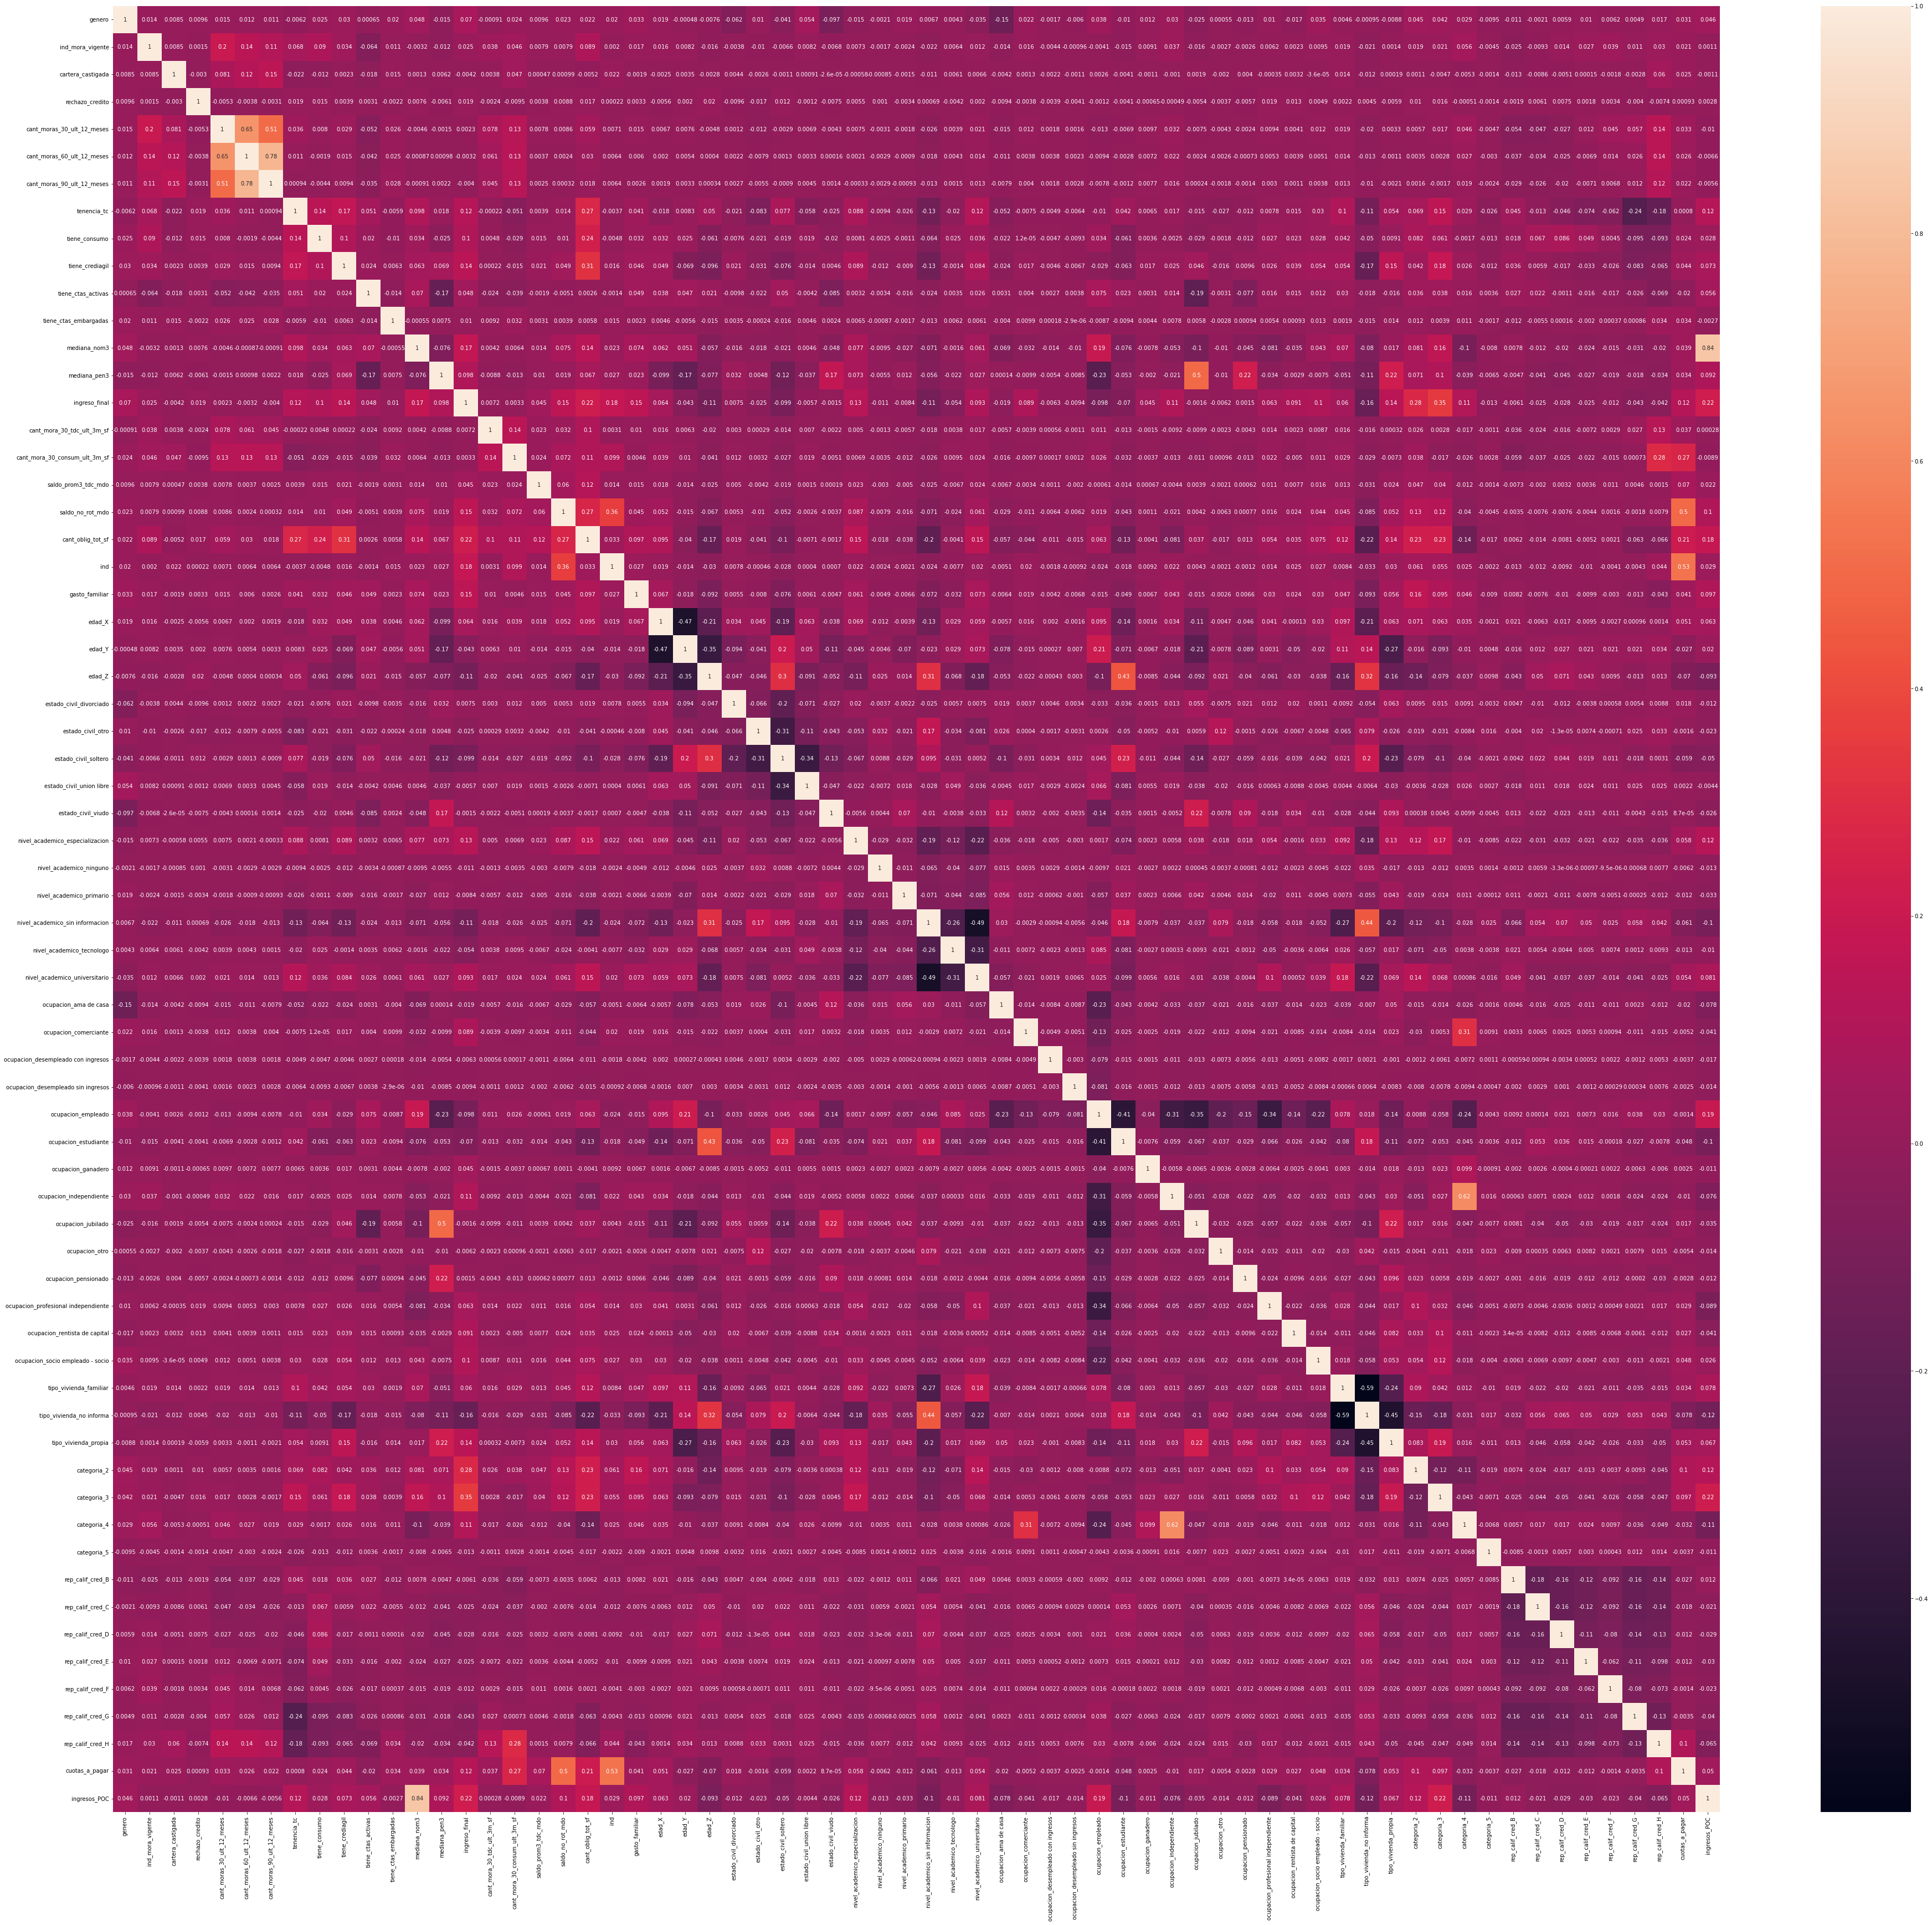

In [180]:
plt.figure(figsize = (65,60))
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## Dataset Final

In [ ]:
df.to_csv("dataClean_new.csv", index = False)